# Predicting Student Dropout with Machine Learning Models

**Author:** Matt Cocker  
**Date:** [May, 2025]  
**Project Type:** Supervised ML | Classification | Education Analytics

---

## About this Notebook

This notebook explores how machine learning models can be applied to predict student dropout risk using structured data on demographics, academic engagement, and behavioural patterns. The goal is to support educational institutions in identifying at-risk students early and enabling targeted intervention.

The notebook includes data preprocessing, model training and evaluation, feature importance analysis, and discussion of actionable outcomes. Both traditional and deep learning models are explored to assess performance and interpretability.

**Key Tasks:**
- Clean and engineer features from enrolment and academic data
- Train multiple models (e.g. XGBoost, neural networks) for dropout classification
- Evaluate using precision/recall and ROC-AUC
- Use SHAP and permutation importance for model explanation
- Reflect on business value and real-world application

*Note: The original dataset used in this notebook is under NDA and not accessible. Any data loading or Drive mounting steps have been replaced with placeholders, and outputs that show the raw data have been cleared.*

# Installations

In [ ]:
!pip install keras-tuner -q

# Imports

In [ ]:
# --- Analysis libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, accuracy_score, recall_score,
                              f1_score, classification_report, precision_score,
                              confusion_matrix, ConfusionMatrixDisplay)
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import shap
from tensorflow import keras
from keras import layers
import keras_tuner as kt
from keras.optimizers import Adam, RMSprop

# --- Admin libraries

import warnings
warnings.filterwarnings('ignore')



The Stage 1 Data consists of basic applicant and course information - this will likely not be sufficient to predict student dropout with a decent degree of accuracy but will be used as a baseline.

# Stage 1 data

In [ ]:
# File URL
url_1 = "stage_1_data"

# Download the Stage 1 data into a DataFrame

stage_1 = pd.read_csv(url_1)
stage_1.head()

In [ ]:
# Use the DateofBirth column to generate an Age feature

stage_1['DateofBirth'] = pd.to_datetime(stage_1['DateofBirth'])
stage_1['Age'] = (pd.to_datetime('today') - stage_1['DateofBirth'])
stage_1['Age'] = stage_1['Age'].dt.days/365.25
stage_1['Age'] = stage_1['Age'].astype(int)
stage_1.head()

The Learner Code, Booking Type, and Lead Source features clearly have no use in the analysis, as such they will be removed, along with the DateofBirth column.


In [ ]:
# Remove the DateofBirth, LearnerCode, BookingType, LeadSource and Nationality features from the dataset

stage_1.drop(['LearnerCode', 'BookingType', 'LeadSource', 'DateofBirth'], axis=1, inplace=True)

 Any columns with more than 50% of data missing will be removed - there are 25,060 rows, so features with over 12,530 values missing will be removed.

In [ ]:
# Count the number of missing values in each column

stage_1.isnull().sum()

,0
CentreName,0
DiscountType,17464
Gender,0
Nationality,0
HomeState,16134
HomeCity,3448
CourseLevel,0
CourseName,0
IsFirstIntake,0
CompletedCourse,0


In [ ]:
# Remove the DiscountType and HomeState features

stage_1.drop(['DiscountType', 'HomeState'], axis=1, inplace=True)

In [ ]:
# Count the number of unique values in each column

stage_1.nunique()

,0
CentreName,19
Gender,2
Nationality,151
HomeCity,5881
CourseLevel,4
CourseName,172
IsFirstIntake,2
CompletedCourse,2
ProgressionDegree,2616
ProgressionUniversity,40


The HomeCity and ProgressionDegree features have over 200 unique values, as such they will be removed, as these would be excessive in one hot encoding.

In [ ]:
# Remove the HomeCity and ProgressionDegree features from the dataset

stage_1.drop(['HomeCity', 'ProgressionDegree'], axis=1, inplace=True)
stage_1.head()

To allow the models to work on the data, we need to perform ordinal encoding for ordinal data. The CourseLevel feature is ordinal.

In [ ]:
# Identify the unique features in the CourseLevel feature

stage_1['CourseLevel'].unique()

array(['Pre-Masters', 'Foundation', 'International Year Two',
       'International Year One'], dtype=object)

The CourseLevel feature will be organised as follows: 1: Foundation, 2: International Year One, 3: International Year Two and 4: Pre-Masters


In [ ]:
# Perform ordinal encoding on the CourseLevel feature

stage_1['CourseLevel'] = stage_1['CourseLevel'].map({'Foundation': 1, 'International Year One': 2, 'International Year Two': 3, 'Pre-Masters': 4})
stage_1.head()

We need to convert the Gender and CompletedCourse features to binary datatype to allow the model to correctly understand them.

We will change the CompletedCourse feature to 'Target' as it is our target variable. As what we are predicting is whether students will drop out, we will ascribe 'No' in CompletedCourse to '1' in Target, as the formulae for the evaluation metrics we will use to assess the model are designed with True Positives (predicted 1s that are indeed 1s) in mind.

In [ ]:
# Convert the Gender and CompletedCourse features to binary datatype

stage_1['Gender'] = stage_1['Gender'].map({'Male': 0, 'Female': 1})
stage_1['CompletedCourse'] = stage_1['CompletedCourse'].map({'Yes': 0, 'No': 1})

# Rename the CompletedCourse feature to 'Target'

stage_1.rename(columns={'CompletedCourse': 'Target'}, inplace=True)
stage_1.head()

Here we are going to save the cleaned dataset, as it will be useful to have access to later.

In [ ]:
# Copy the cleaned data to a new DataFrame

clean = stage_1.copy()
clean.head()

To allow the models to work on the data, we need to perform one-hot encoding for the categorical data. The CentreName, CourseName and Progression University features are categorical. We use ```drop='first'``` to drop one variable to eliminate multicollinearity.

In [ ]:
# Perform One-Hot Encoding

encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_features_1 = encoder.fit_transform(stage_1[['CentreName', 'CourseName', 'ProgressionUniversity','Nationality']])
encoded_1 = pd.DataFrame(encoded_features_1, columns=encoder.get_feature_names_out(['CentreName', 'CourseName', 'ProgressionUniversity','Nationality']))
stage_1 = pd.concat([stage_1, encoded_1], axis=1)
stage_1.drop(['CentreName', 'CourseName', 'ProgressionUniversity','Nationality'], axis=1, inplace=True)
stage_1.head()

Check for imbalance in the Target variable.

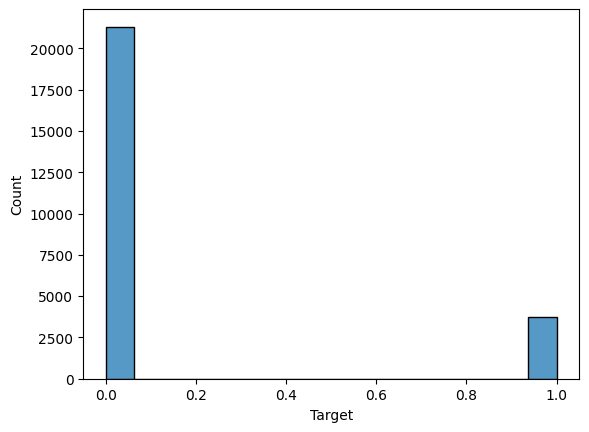

In [ ]:
# Plot the Target feature on a histogram

sns.histplot(stage_1['Target'])
plt.show()

The data is clearly imbalanced, however that is clearly representative of reality (the vast majority of people do not drop out of higher education) therefore the model will be built using this data.

If the models are incapable of achieving the required accuracy, it may be prudent to weight the students who drop out higher than those that don't to force the model to focus its learning on predicting dropout using that data.

We'll split the data into inputs, X, and output, y. Then we'll split the data into a training and test set.

In [ ]:
# Split the data into X and y

X = stage_1.drop('Target', axis=1)
y = stage_1['Target']

# Split X into a training and test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

Now we'll build a predictive model - we'll start with XGBoost.

In [ ]:
# Instantiate the XGBoost model

model_xg1 = XGBClassifier(random_state=19)
model_xg1.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=19, ...)

Print accuracy, precision, recall, F1 and AUC for the model, as well as the confusion matrix.

Accuracy: 0.89
Precision: 0.69
Recall: 0.51
F1: 0.59
AUC: 0.74


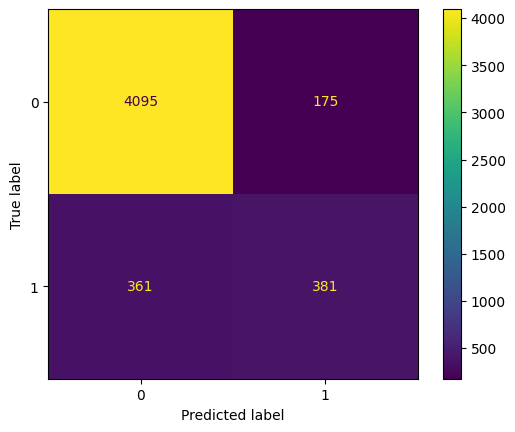

In [ ]:
# Run the model on the test set

pred_xg1 = model_xg1.predict(X_test)

# Print the evaluation metrics to 2 significant figures

print(f'Accuracy: {accuracy_score(y_test, pred_xg1):.2f}')
print(f'Precision: {precision_score(y_test, pred_xg1):.2f}')
print(f'Recall: {recall_score(y_test, pred_xg1):.2f}')
print(f'F1: {f1_score(y_test, pred_xg1):.2f}')
print(f'AUC: {roc_auc_score(y_test, pred_xg1):.2f}')
cm_xg1 = confusion_matrix(y_test, pred_xg1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xg1, display_labels=model_xg1.classes_)
disp.plot()
plt.show()

This performance is frankly poor; as such we will tune the Learning Rate, Max Depth, and Number of Estimators parameters using Grid Search.

As we are aiming to accurately predict students who are likely to drop out, Recall is the score we should aim to optimise. This is because there is not a significant cost to a False Negative (providing extra help to a student who was not likely to drop out contrary to the model's prediction) as there could be in another scenario (medical diagnosis). This metric is also robust against imbalanced data, which is useful for the given dataset.

In [ ]:
# Set up the grid

param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [ 10, 15, 20, 30],
    'n_estimators': [50, 100, 200]
}

# Instantiate the model

model_xg1_tune = XGBClassifier(random_state=19)

# Perform Grid Search

grid_search1 = GridSearchCV(model_xg1_tune, param_grid, scoring='recall', cv=5)
grid_search1.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=19, ...),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [10, 15, 20, 30],
                         'n_estimators': [50, 100, 200]},
             scoring='recall')

In [ ]:
# Print the best parameters and the best score

print(f'Best parameters: {grid_search1.best_params_}')
print(f'Best score: {grid_search1.best_score_:.2f}')

Best parameters: {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 100}
Best score: 0.56


Having found the best parameters, we will now view the accuracy, precision, recall and AUC for the best XGBoost model, as well as the confusion matrix.

Accuracy: 0.89
Precision: 0.67
Recall: 0.51
F1: 0.58
AUC: 0.73


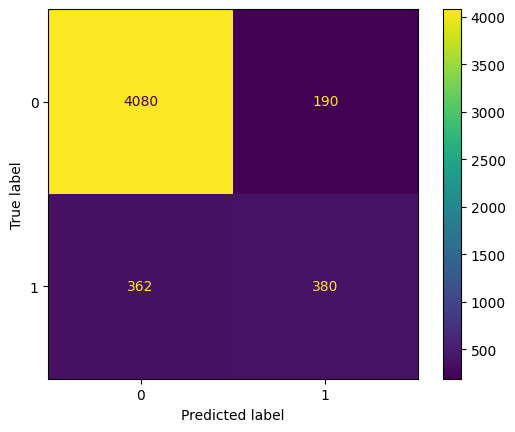

In [ ]:
# Instantiate the best model

model_xg1_opt = grid_search1.best_estimator_

# Run the best model on the test set

pred_xg1_opt = model_xg1_opt.predict(X_test)

# Print the accuracy, precision, recall, F1 and AUC for the model, as well as the confusion matrix

print(f'Accuracy: {accuracy_score(y_test, pred_xg1_opt):.2f}')
print(f'Precision: {precision_score(y_test, pred_xg1_opt):.2f}')
print(f'Recall: {recall_score(y_test, pred_xg1_opt):.2f}')
print(f'F1: {f1_score(y_test, pred_xg1_opt):.2f}')
print(f'AUC: {roc_auc_score(y_test, pred_xg1_opt):.2f}')
cm_xg1_opt = confusion_matrix(y_test, pred_xg1_opt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xg1_opt, display_labels=model_xg1_opt.classes_)
disp.plot()
plt.show()

Whilst hyperparameter tuning has improved model performance to an extent, it is still sorely lacking. Either XGBoost is not an appropriate model, or the Stage 1 dataset does not provide the model with sufficient data to make good predictions.

We will now use SHAP to analyse feature importance in the model.

In [ ]:
# Initialise SHAP
shap.initjs()

# Explain the model and create a DataFrame of the SHAP values

shap_ex = shap.TreeExplainer(model_xg1_opt)
vals1 = shap_ex(X_test)
vals1_df = pd.DataFrame(vals1.values, columns=X_test.columns, index=X_test.index)
vals1_df


,Gender,CourseLevel,IsFirstIntake,Age,CentreName_ISC_Aberdeen,CentreName_ISC_Cardiff,CentreName_ISC_Dublin,CentreName_ISC_Durham,CentreName_ISC_Holland,CentreName_ISC_Huddersfield,...,Nationality_Turkmen,Nationality_Ugandan,Nationality_Ukrainian,Nationality_Uruguayan,Nationality_Uzbek,Nationality_Venezuelan,Nationality_Vietnamese,Nationality_Yemeni,Nationality_Zambian,Nationality_Zimbabwean
15261,-0.224617,-0.858701,-0.013978,-0.196318,0.000008,-0.002769,-0.003532,0.012194,0.003153,0.003004,...,0.0,0.000080,-0.001084,0.0,0.0,0.0,-0.003768,-0.000821,-0.000037,0.000017
6851,-0.272824,-0.466384,0.059208,-0.000231,0.000709,-0.013442,-0.002621,0.018599,0.005107,0.066113,...,0.0,0.000079,-0.001197,0.0,0.0,0.0,-0.003145,-0.000953,-0.000026,0.000017
12173,0.070681,-0.272554,0.016064,-0.080185,-0.002547,-0.003938,-0.004142,0.017660,0.004560,-0.010754,...,0.0,0.000086,-0.001623,0.0,0.0,0.0,-0.002515,-0.000964,-0.000039,0.000030
8441,-0.177055,0.203675,0.014761,0.229496,-0.001945,-0.001164,-0.004037,0.028677,0.005590,-0.004152,...,0.0,0.000079,-0.001294,0.0,0.0,0.0,-0.005019,-0.001001,-0.000039,0.000030
21141,0.093065,0.215786,0.025329,-0.127260,-0.003547,0.040822,-0.070862,0.019003,0.005995,-0.014221,...,0.0,0.000079,-0.002128,0.0,0.0,0.0,-0.006647,-0.001180,-0.000134,0.000085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7676,0.141011,0.051301,0.116383,0.027409,-0.008228,-0.006552,-0.005268,0.020608,0.005203,0.014881,...,0.0,0.000079,-0.001557,0.0,0.0,0.0,-0.004747,-0.001113,-0.000039,0.000029
20410,-0.002919,0.123917,0.023375,-0.419032,-0.001877,0.024675,-0.009680,0.007901,0.003920,-0.017013,...,0.0,0.000079,-0.001630,0.0,0.0,0.0,-0.009477,-0.001004,-0.000134,0.000085
17705,-0.035533,-0.941168,0.069455,0.070782,0.003323,-0.007484,-0.008582,0.002793,0.006115,0.010158,...,0.0,0.000079,-0.001188,0.0,0.0,0.0,-0.002506,-0.000816,-0.000037,0.000017
13749,0.192683,0.170450,0.009373,0.094062,-0.004179,-0.004751,-0.015288,0.004080,0.004999,-0.005428,...,0.0,0.000079,-0.001864,0.0,0.0,0.0,-0.005246,-0.001981,-0.000065,0.000031


Having obtained the values, we will now plot a beeswarm plot.

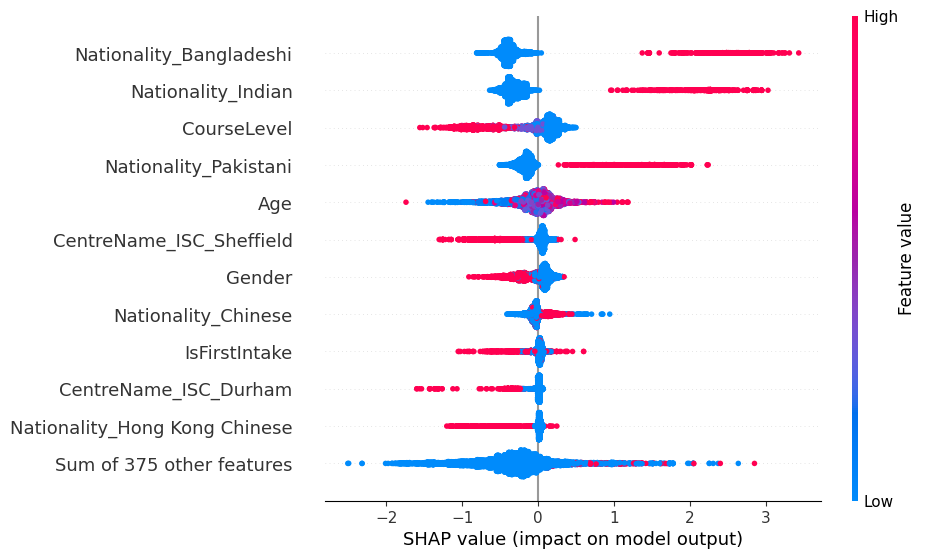

In [ ]:
# Plot the beeswarm plot for feature importance

shap.plots.beeswarm(vals1, max_display=12)
plt.show()

The beeswarm plot shows that the model identifies nationality as a predictor of dropout - the model believes students who are Bangladeshi, Indian or Pakistani are more likely to drop out. This may be related to language skills and, if the model showed better performance, could be something for Study Group to focus on.

The plot also identifies Course Level as an important feature, with the model predicting that students are more likely to drop out from lower level courses; perhaps because they are less committed than they would be at higher levels.

There are likely too many variables here - in future iterations of this project we will spend more time examining feature importance to generate a good input dataset.

---



Having built, trained and optimised an XGBoost model, we will now build a Neural Network to compare the predictive power of the two models. To start with, we will split the training data into training and validation and scale the two.

In [ ]:
# Split the training set into training and validation

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=19)

# Scale the training and validation sets

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


Now we will create a neural network with one hidden layer, 64 neurons and the ReLu activation function. We will use the Adam optimiser.

In [ ]:
# Instantiate the neural network

model_nn1 = keras.Sequential()
model_nn1.add(layers.Dense(64, activation='relu', input_dim=X_train_scaled.shape[1]))
model_nn1.add(layers.Dense(1, activation='sigmoid'))

model_nn1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','recall'])

We will use 30 epochs to ensure the model is not underfit. We will start with a batch size of 64.

In [ ]:
batch_size = 64

epochs = 30

model_nn1.fit(X_train_scaled, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_val_scaled, y_val),
          verbose=0)

We will plot the recall and loss across epochs for this initial model.

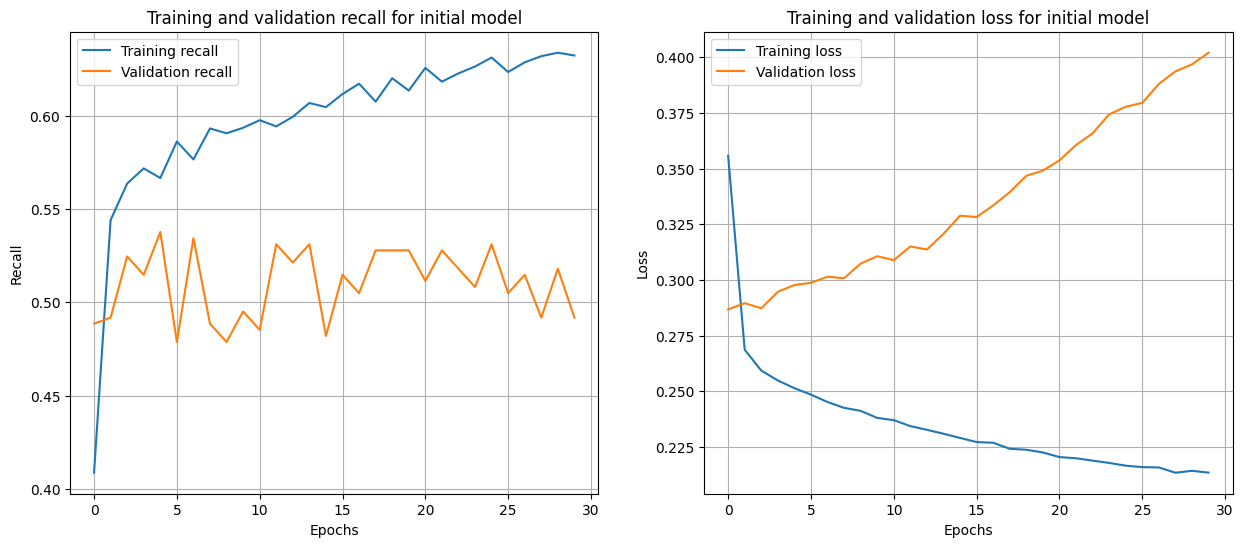

In [ ]:
# Plot the model recall and loss

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(model_nn1.history.history['recall'], label='Training recall')
plt.plot(model_nn1.history.history['val_recall'], label='Validation recall')
plt.title(f'Training and validation recall for initial model')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(model_nn1.history.history['loss'], label='Training loss')
plt.plot(model_nn1.history.history['val_loss'], label='Validation loss')
plt.title(f'Training and validation loss for initial model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

There is significant instability through the epochs, as well as clear evidence of overfitting. This will need to be fixed when tuning.

Print accuracy, precision, recall, F1 and AUC for the model, as well as the confusion matrix.

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.89
Precision: 0.67
Recall: 0.48
F1: 0.56
AUC: 0.72


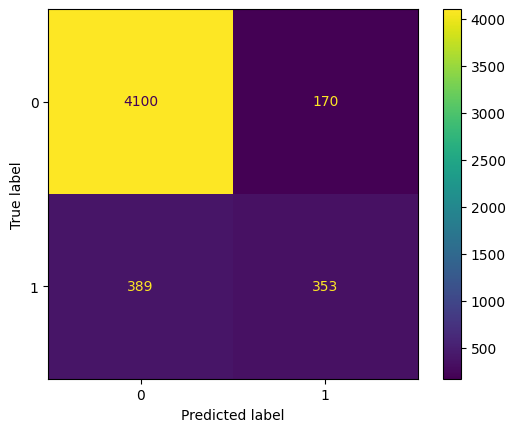

In [ ]:
# Print accuracy, precision, recall, F1 and AUC for the model

pred_nn1 = model_nn1.predict(X_test_scaled)

print(f'Accuracy: {accuracy_score(y_test, pred_nn1.round()):.2f}')
print(f'Precision: {precision_score(y_test, pred_nn1.round()):.2f}')
print(f'Recall: {recall_score(y_test, pred_nn1.round()):.2f}')
print(f'F1: {f1_score(y_test, pred_nn1.round()):.2f}')
print(f'AUC: {roc_auc_score(y_test, pred_nn1.round()):.2f}')

# Print the confusion matrix for the model

cm_nn1 = confusion_matrix(y_test, pred_nn1.round())
disp_nn1 = ConfusionMatrixDisplay(confusion_matrix=cm_nn1)
disp_nn1.plot()
plt.show()

This performance is also poor and can clearly be improved; as such we need to tune the hyperparameters. To do this, we will use Keras Tuner. We will start with number of layers, number of neurons and activation function, as those are the hyperparameters that most significantly impact performance.

Once those are established, other metrics such as the optimiser, dropout, and learning rate, will be tuned - these are grouped together as tuning these will reduce instability through the epochs. Batch size will be tuned at this point as well.

As above, we will optimise for recall, as we are aiming to maximise our ability to accuractely predict students who are likely to churn.

In [ ]:
# Define the search space

def build_model_tune1(hp):
    model = keras.Sequential()

    # Add the input layer
    model.add(layers.Flatten())

        # Tune the number of layers
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(
            layers.Dense(

        # Tune the number of neurons
                units=hp.Int('units', min_value=16, max_value=128, step=16),

        # Tune the activation function
                activation=hp.Choice('activation', ['relu', 'sigmoid', 'tanh']),
            ))

    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['recall'])

    return model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.7 MB/s eta 0:00:00


In [ ]:
# Set up the search

tuner_s1_1 = kt.RandomSearch(build_model_tune1,
                        objective='val_recall',
                        max_trials=25,
                        overwrite=True)

# Run the search, implementing early stopping to conserve computational power

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner_s1_1.search(X_train_scaled, y_train, epochs=30, validation_data=(X_val_scaled, y_val), callbacks=[early_stopping])

Trial 25 Complete [00h 00m 35s]
val_recall: 0.5409836173057556

Best val_recall So Far: 0.6000000238418579
Total elapsed time: 00h 13m 10s


In [ ]:
# Return the best model

model_nn1_tuned1 = tuner_s1_1.get_best_models(num_models=1)[0]
model_nn1_tuned1.summary()

tuner_s1_1.results_summary(1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 386)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 112)            │        43,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 112)            │        12,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 112)            │        12,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           113 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,769 (268.63 KB)

 Trainable params: 68,769 (268.63 KB)

 Non-trainable params: 0 (0.00 B)

Results summary
Results in ./untitled_project
Showing 1 best trials
Objective(name="val_recall", direction="max")

Trial 08 summary
Hyperparameters:
num_layers: 3
units: 112
activation: sigmoid
Score: 0.6000000238418579


Tuning the hyperparameters has greatly improved recall, from 0.35 in the initial neural network to 0.51 (albeit the tuned neural network has not been run on the test set yet so the comparison is not exact). However, this is still extremely limited in terms of predictive power. This would suggest that the input data (or lack thereof) is the issue, rather than either of the models.

We will plot the recall and loss curves to examine how our model performs across epochs.

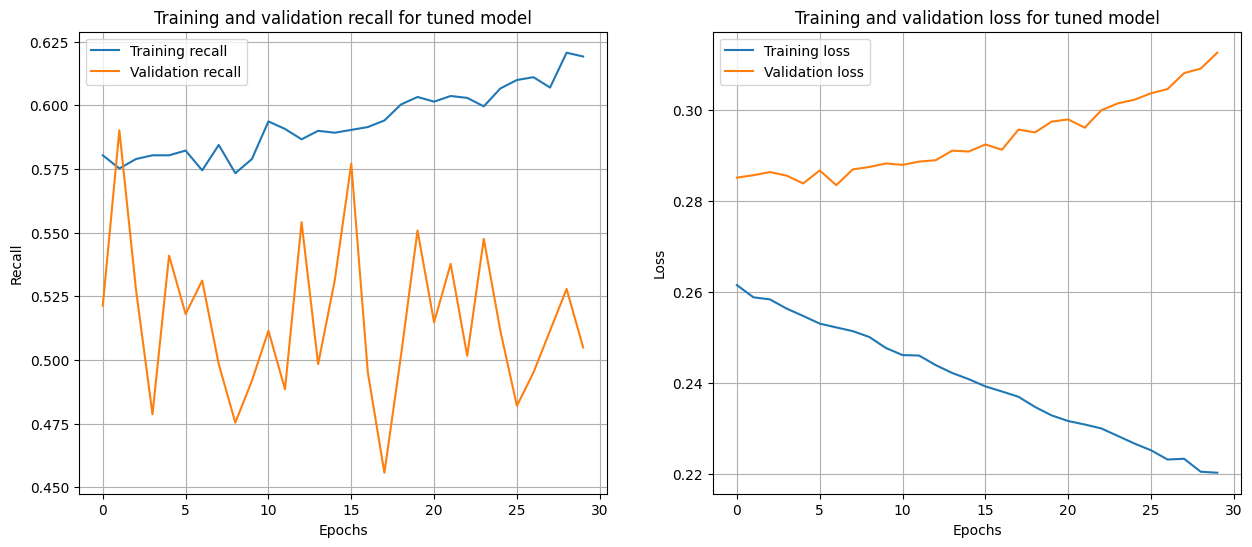

In [ ]:
# Plot the recall and loss curves

history = model_nn1_tuned1.fit(X_train_scaled, y_train,
                               epochs=30, batch_size=128,
                               validation_data=(X_val_scaled, y_val),
                               verbose=0)


plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(model_nn1_tuned1.history.history['recall'], label='Training recall')
plt.plot(model_nn1_tuned1.history.history['val_recall'], label='Validation recall')
plt.title(f'Training and validation recall for tuned model')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(model_nn1_tuned1.history.history['loss'], label='Training loss')
plt.plot(model_nn1_tuned1.history.history['val_loss'], label='Validation loss')
plt.title(f'Training and validation loss for tuned model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

Training recall and validation loss show some instability and validation recall is extremely volatile; as such we need to tune the optimiser function and learning rate. We will also tune dropout to ensure overfitting is prevented - the rise in validation loss as training loss falls suggests that some may be present.

Ideally, these would have been trained alongside the number layers, neurons and activation function, and more trials would have been done, however they have been split out due to limited computational resources.

In [ ]:
# Extract the number of layers, number of neurons and activation function from the 1st round of hyperparameter tuning

best_hps_1 = tuner_s1_1.get_best_hyperparameters(num_trials=1)[0]

num_layers_s1 = best_hps_1.get('num_layers')
num_neurons_s1 = best_hps_1.get('units')
activation_s1 = best_hps_1.get('activation')

In [ ]:
# Define the search space, passing the fixed best hyperparameters
def build_model_tune2(hp, num_layers, num_neurons, activation):
    model = keras.Sequential()

    # Add the input layer
    model.add(layers.Flatten())

    # Use the fixed number of layers, neurons, and activation function
    for i in range(num_layers):
        model.add(
            layers.Dense(
                units=num_neurons,        # Use the fixed number of neurons
                activation=activation,  # Use the fixed activation function
            ))

        # Tune whether to add Dropout *after* each hidden layer
        if hp.Boolean('use_dropout_' + str(i)): # Give each dropout a unique name
            # Tune the dropout rate
            dropout_rate = hp.Float('dropout_rate_' + str(i), min_value=0.0, max_value=0.5, step=0.05) # Give each dropout rate a unique name
            model.add(layers.Dropout(dropout_rate))

    # Add the output layer
    model.add(layers.Dense(1, activation='sigmoid'))

    # Tune the optimiser
    optimiser_name = hp.Choice('optimiser', ['adam', 'rmsprop'])

    # Tune the learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    # Map the optimiser name to the optimizer class and instantiate
    from tensorflow.keras.optimizers import Adam, RMSprop

    if optimiser_name == 'adam':
        optimiser = Adam(learning_rate=learning_rate)
    elif optimiser_name == 'rmsprop':
        optimiser = RMSprop(learning_rate=learning_rate)
    else:
        # Default to Adam if something unexpected happens
        optimiser = Adam(learning_rate=learning_rate)


    model.compile(optimizer=optimiser, loss='binary_crossentropy', metrics=['recall'])

    return model

In [ ]:
# Set up the search, passing the fixed hyperparameters to the build function
tuner_s1_2 = kt.RandomSearch(
    lambda hp: build_model_tune2(hp,
                                 num_layers=num_layers_s1,
                                 num_neurons=num_neurons_s1,
                                 activation=activation_s1), # Pass the fixed hyperparameters here
    objective='val_recall',
    max_trials=25,
    overwrite=True)

# Run the search, implementing early stopping to conserve computational power
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner_s1_2.search(X_train_scaled, y_train, epochs=30, validation_data=(X_val_scaled, y_val), callbacks=[early_stopping])

Trial 25 Complete [00h 01m 06s]
val_recall: 0.5573770403862

Best val_recall So Far: 0.6590163707733154
Total elapsed time: 00h 23m 32s


In [ ]:
# Return the best model

model_nn1_tuned2 = tuner_s1_2.get_best_models(num_models=1)[0]
model_nn1_tuned2.summary()

tuner_s1_2.results_summary(1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 386)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 112)            │        43,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 112)            │        12,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 112)            │        12,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           113 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,769 (268.63 KB)

 Trainable params: 68,769 (268.63 KB)

 Non-trainable params: 0 (0.00 B)

Results summary
Results in ./untitled_project
Showing 1 best trials
Objective(name="val_recall", direction="max")

Trial 13 summary
Hyperparameters:
use_dropout_0: True
use_dropout_1: False
use_dropout_2: False
optimiser: adam
learning_rate: 0.009724566868291375
dropout_rate_0: 0.05
dropout_rate_1: 0.4
dropout_rate_2: 0.05
Score: 0.6590163707733154


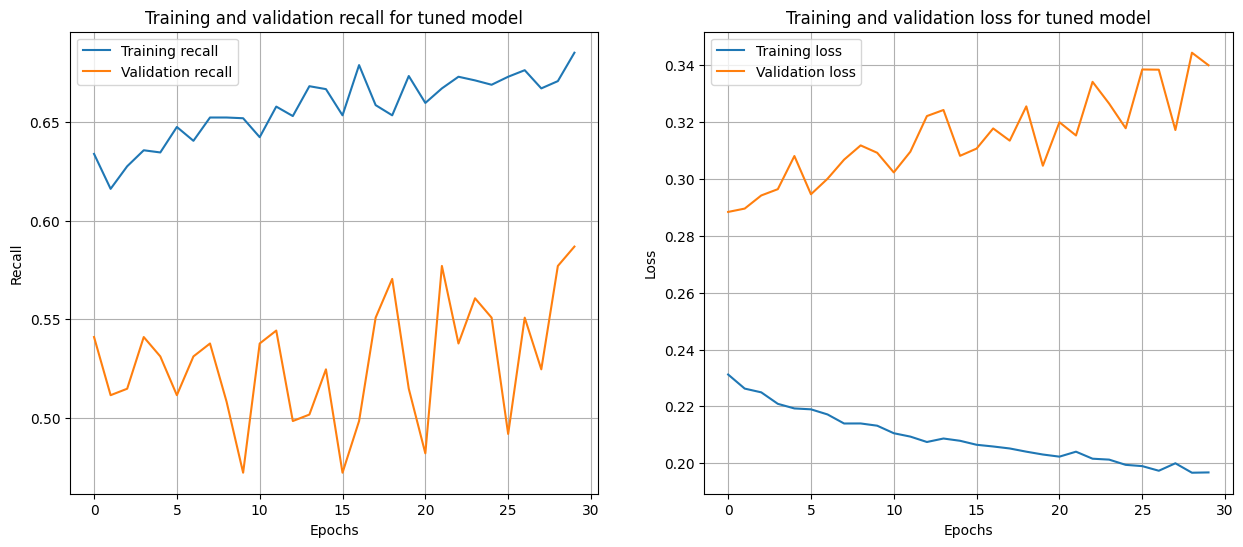

In [ ]:
# Plot the recall and loss curves

history = model_nn1_tuned2.fit(X_train_scaled, y_train,
                               epochs=30, batch_size=128,
                               validation_data=(X_val_scaled, y_val),
                               verbose=0)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(model_nn1_tuned2.history.history['recall'], label='Training recall')
plt.plot(model_nn1_tuned2.history.history['val_recall'], label='Validation recall')
plt.title(f'Training and validation recall for tuned model')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(model_nn1_tuned2.history.history['loss'], label='Training loss')
plt.plot(model_nn1_tuned2.history.history['val_loss'], label='Validation loss')
plt.title(f'Training and validation loss for tuned model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

Training and validation recall have further improved, suggesting we are getting close to an optimal model. Unfortunately, tuning the optimiser function and learning rate have not significantly reduction the volatility in validation recall. To attempt to fix this, we will tune the batch size.

In [ ]:
# Extract the optimiser and learning rate from the 2nd round of hyperparameter tuning

best_hps_2 = tuner_s1_2.get_best_hyperparameters(num_trials=1)[0]

optimiser_s1 = best_hps_2.get('optimiser')
learning_rate_s1 = best_hps_2.get('learning_rate')

# Determine the dropout rate and whether dropout was used for each layer
dropout_rates = {}
use_dropout = {}
for i in range(num_layers_s1):
    # Check if the boolean choice for dropout existed and was True for this layer
    dropout_key = f'use_dropout_{i}'
    if dropout_key in best_hps_2.values and best_hps_2.get(dropout_key) is True:
        use_dropout[i] = True
        # Only get the dropout rate if dropout was used for this layer
        dropout_rate_key = f'dropout_rate_{i}'
        if dropout_rate_key in best_hps_2.values:
             dropout_rates[i] = best_hps_2.get(dropout_rate_key)
        else:
             # If dropout was True but the rate wasn't tuned (e.g., if it was fixed at 0.0 in tuning setup)
             dropout_rates[i] = 0.0
    else:
        use_dropout[i] = False
        dropout_rates[i] = 0.0 # Default to 0.0 if dropout was not used for this layer

In [ ]:
# Instantiate the optimal model

model_nn1_opt = keras.Sequential()
model_nn1_opt.add(layers.Flatten())

# Add the hidden layers with the optimal number of neurons and activation function
for i in range(num_layers_s1):
    model_nn1_opt.add(layers.Dense(units=num_neurons_s1, activation=activation_s1))
    # Add dropout if it was found to be optimal for this layer
    if use_dropout.get(i, False): # Check if dropout was tuned for this layer and if it was True
        model_nn1_opt.add(layers.Dropout(dropout_rates.get(i, 0.0))) # Use the tuned dropout rate

# Add the output layer
model_nn1_opt.add(layers.Dense(1, activation='sigmoid'))

# Compile the model with the optimal optimizer and learning rate

if optimiser_s1 == 'adam':
    optimiser = Adam(learning_rate=learning_rate_s1)
elif optimiser_s1 == 'rmsprop':
    optimiser = RMSprop(learning_rate=learning_rate_s1)
else:
    # Default to Adam if something unexpected happens
    optimiser = Adam(learning_rate=learning_rate_s1)


model_nn1_opt.compile(optimizer=optimiser, loss='binary_crossentropy', metrics=['recall'])


Training with batch size: 32
Training with batch size: 64
Training with batch size: 128
Training with batch size: 256


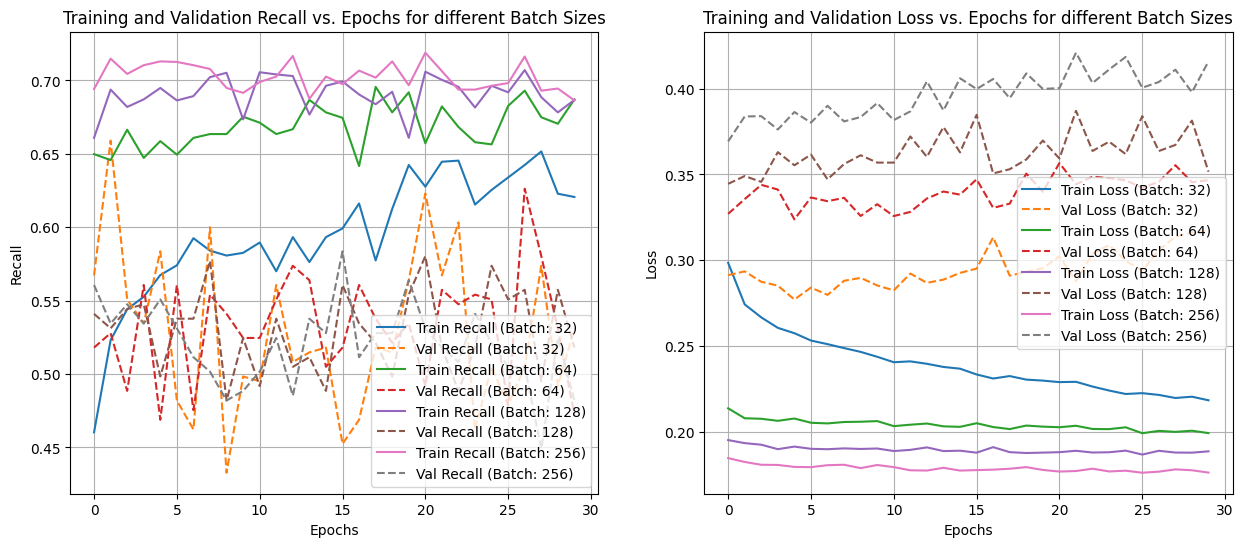

In [ ]:
# Tune the batch size

batch_sizes = [32, 64, 128, 256]

# List to store history objects for each batch size
histories = []

for batch_size in batch_sizes:
    print(f"Training with batch size: {batch_size}")
    # Train the model and store the history
    history = model_nn1_opt.fit(X_train_scaled, y_train,
                                epochs=30,
                                batch_size=batch_size,
                                validation_data=(X_val_scaled, y_val),
                                verbose=0)
    histories.append((batch_size, history)) # Store batch size along with history

# Visualise the recall and loss curves for each batch size

plt.figure(figsize=(15, 6))

# Subplot for Recall
plt.subplot(1, 2, 1)
for batch_size, history in histories:
    plt.plot(history.history['recall'], label=f'Train Recall (Batch: {batch_size})')
    plt.plot(history.history['val_recall'], label=f'Val Recall (Batch: {batch_size})', linestyle='--') # Using dashed line for validation for clarity

plt.title('Training and Validation Recall vs. Epochs for different Batch Sizes')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

# Subplot for Loss
plt.subplot(1, 2, 2)
for batch_size, history in histories:
    plt.plot(history.history['loss'], label=f'Train Loss (Batch: {batch_size})')
    plt.plot(history.history['val_loss'], label=f'Val Loss (Batch: {batch_size})', linestyle='--') # Using dashed line for validation for clarity

plt.title('Training and Validation Loss vs. Epochs for different Batch Sizes')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()


Tuning the batch size seemingly has little to no impact on the volatility of validation recall. As such, we will stick with a batch size of 128 for the remainder of this project.

Perhaps tuning a different hyperparameter, such as regularisation, or trying an optimiser such as Nadam or Adagrad would fix it. However, given the performance of the model is so limited, it would not be prudent to spend time tuning it for stability, as it has no practical use at this level of recall, and the volatility may simply be a feature of the input data.

In [ ]:
# Retrain the optimal model, using early stopping and the optimal batch size

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model_nn1_opt.fit(X_train_scaled, y_train,
                            epochs=30, batch_size=128,
                            validation_data=(X_val_scaled, y_val),
                            callbacks=early_stopping,
                            verbose=0)

model_nn1_opt.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 386)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 112)            │        43,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 112)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 112)            │        12,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 112)            │        12,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           113 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,309 (805.90 KB)

 Trainable params: 68,769 (268.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 137,540 (537.27 KB)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.89
Precision: 0.67
Recall: 0.50
F1: 0.57
AUC: 0.73


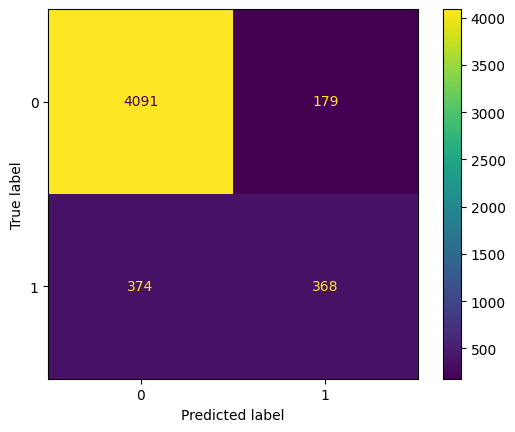

In [ ]:
# Evaluate the model on the test dataset

pred_nn1_tuned1 = model_nn1_tuned1.predict(X_test_scaled)

# Print the evaluation metrics for the model

print(f'Accuracy: {accuracy_score(y_test, pred_nn1_tuned1.round()):.2f}')
print(f'Precision: {precision_score(y_test, pred_nn1_tuned1.round()):.2f}')
print(f'Recall: {recall_score(y_test, pred_nn1_tuned1.round()):.2f}')
print(f'F1: {f1_score(y_test, pred_nn1_tuned1.round()):.2f}')
print(f'AUC: {roc_auc_score(y_test, pred_nn1_tuned1.round()):.2f}')

# Print the confusion matrix for the model

cm_nn1_t = confusion_matrix(y_test, pred_nn1_tuned1.round())
disp_nn1_t = ConfusionMatrixDisplay(confusion_matrix=cm_nn1_t)
disp_nn1_t.plot()
plt.show()

The model performance on the test dataset is significantly worse than on the training dataset. There are several possibilities for this. The test dataset could, by coincidence, be very different from the training and validation sets. The model could be overfitting (although the dropout would make that unlikely) or the test set could coincidentally be extremely different from the training set.

What is most likely is that the input data is simply not sufficient to predict student dropout rate - this is not surprising as the input data is made up of generic features such as Age and Gender. Features which show more individuality should better predict whether an individual student is likely to drop out.

We would expect model performance to improve when more input features are added to the data in Stage 2 and Stage 3.

# Stage 2 data

In [ ]:
# File URL
url_2 = "stage_2_data"

# Import the Stage 2 dataset into a DataFrame

df_2 = pd.read_csv(url_2)
df_2.head()

To save time and computational resources, and for simplicity's sake, we will use the cleaned dataset from Stage 1, with the new features from the Stage 2 dataset appended.

In [ ]:
# Create the Stage 2 dataset as the cleaned dataset plus the AuthorisedAbsenceCount and UnauthorisedAbsenceCount features

stage_2 = clean.copy()
stage_2['AuthorisedAbsenceCount'] = df_2['AuthorisedAbsenceCount']
stage_2['UnauthorisedAbsenceCount'] = df_2['UnauthorisedAbsenceCount']
stage_2.head()

Once again, we will copy the cleaned dataset for future reference, as it will be used in Stage 3.

In [ ]:
# Copy the cleaned dataset

clean2 = stage_2.copy()

We will check the proportion of rows which have missing values.

In [ ]:
# Count the number of rows with missing values

missing_rows = stage_2.isnull().any(axis=1).sum()

# Show that as a proportion of total rows

prop_missing_rows = (missing_rows / stage_2.shape[0])
print(f'Proportion of rows which have missing values: {prop_missing_rows:.3f}')

Proportion of rows which have missing values: 0.008


This is below 2%, therefore all rows with missing values will be removed, as this is favoured to imputing data.

In [ ]:
# Remove all rows with missing values from the dataset.

stage_2 = stage_2.dropna()

# Reset the index (because otherwise One-Hot Encoding introduces missing values)

stage_2 = stage_2.reset_index(drop=True)

# Double check by showing the new number of rows

stage_2.shape

(24851, 11)

Once again, we need to one-hot encode the cardinal features. Both the new features in Stage 2 are ordinal, therefore this applies to the same features as in Stage 1 - CentreName, CourseName and ProgressionUniversity.

In [ ]:
# Perform One-Hot Encoding

encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_features_2 = encoder.fit_transform(stage_2[['CentreName', 'CourseName', 'ProgressionUniversity','Nationality']])
encoded_2 = pd.DataFrame(encoded_features_2, columns=encoder.get_feature_names_out(['CentreName', 'CourseName', 'ProgressionUniversity','Nationality']))
stage_2 = pd.concat([stage_2, encoded_2], axis=1)
stage_2.drop(['CentreName', 'CourseName', 'ProgressionUniversity','Nationality'], axis=1, inplace=True)
stage_2.head()

Having created the cleaned Stage 2 dataset, we are now ready to start building our models. We will start by splitting the data into X and y, then splitting those into training and test sets.

In [ ]:
# Split the data into X and y

X2 = stage_2.drop('Target', axis=1)
y2 = stage_2['Target']

# Split X into a training and test set

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=19)

As the Stage 1 model has been trained on a portion of the Stage 2 dataset, we will use the final models we built in Stage 1 as the initial models in Stage 2. This will be done manually for XGBoost, as the hyperparameters are relatively simple.

In [ ]:
# Instantiate the XGBoost model using the optimal parameters from Stage 1

model_xg2 = XGBClassifier(learning_rate=0.1, max_depth=20, n_estimators=200, random_state=19)
model_xg2.fit(X2_train, y2_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=19, ...)

Accuracy: 0.91
Precision: 0.71
Recall: 0.57
F1: 0.63
AUC: 0.77


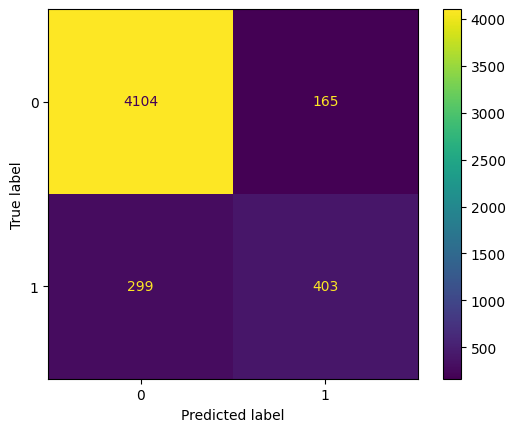

In [ ]:
# Run the model on the test set

pred_xg2 = model_xg2.predict(X2_test)

# Print the evaluation metrics to 2 significant figures

print(f'Accuracy: {accuracy_score(y2_test, pred_xg2):.2f}')
print(f'Precision: {precision_score(y2_test, pred_xg2):.2f}')
print(f'Recall: {recall_score(y2_test, pred_xg2):.2f}')
print(f'F1: {f1_score(y2_test, pred_xg2):.2f}')
print(f'AUC: {roc_auc_score(y2_test, pred_xg2):.2f}')
cm_xg2 = confusion_matrix(y2_test, pred_xg2)
disp_xg2 = ConfusionMatrixDisplay(confusion_matrix=cm_xg2, display_labels=model_xg2.classes_)
disp_xg2.plot()
plt.show()

This is an improvement on both the initial and tuned XGBoost models from the Stage 1 dataset in terms of performance. This would support our hypothesis that the Stage 1 dataset did not have sufficient features to create a model with good predictive power.

We will now build a neural network using the Stage 2 dataset to compare it to the Stage 1 dataset. We will use the hyperparameters from optimal model from the Stage 1 dataset as a starting point. This will be done automatically, as the model is somewhat complex.

To start with, we will split the Stage 2 training dataset into training and validation sets and scale it.

In [ ]:
# Split the training set into training and validation

X_train2, X_val2, y_train2, y_val2 = train_test_split(X2_train, y2_train, test_size=0.2, random_state=19)

# Scale the training and validation sets

scaler = StandardScaler()
X_train_scaled2 = scaler.fit_transform(X_train2)
X_val_scaled2 = scaler.transform(X_val2)
X_test_scaled2 = scaler.transform(X2_test)

In [ ]:
# Instantiate the optimal model

model_nn2 = keras.Sequential()
model_nn2.add(layers.Flatten())

# Add the hidden layers with the optimal number of neurons and activation function
for i in range(num_layers_s1):
    model_nn2.add(layers.Dense(units=num_neurons_s1, activation=activation_s1))
    # Add dropout if it was found to be optimal for this layer
    if use_dropout.get(i, False): # Check if dropout was tuned for this layer and if it was True
        model_nn2.add(layers.Dropout(dropout_rates.get(i, 0.0))) # Use the tuned dropout rate

# Add the output layer
model_nn2.add(layers.Dense(1, activation='sigmoid'))

# Compile the model with the optimal optimizer and learning rate

if optimiser_s1 == 'adam':
    optimizer = Adam(learning_rate=learning_rate_s1)
elif optimiser_s1 == 'rmsprop':
    optimizer = RMSprop(learning_rate=learning_rate_s1)
else:
    # Default to Adam if something unexpected happens
    optimizer = Adam(learning_rate=learning_rate_s1)


model_nn2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['recall'])


In [ ]:
# Retrain the optimal model, using early stopping and the optimal batch size

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model_nn2.fit(X_train_scaled2, y_train2,
                            epochs=30, batch_size=128,
                            validation_data=(X_val_scaled2, y_val2),
                            callbacks=early_stopping,
                            verbose=0)

model_nn2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 386)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 112)            │        43,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 112)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 112)            │        12,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 112)            │        12,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           113 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,309 (805.90 KB)

 Trainable params: 68,769 (268.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 137,540 (537.27 KB)

Having trained the model, we will run it on the test set and print the evaluation metrics.

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.90
Precision: 0.71
Recall: 0.51
F1: 0.59
AUC: 0.74


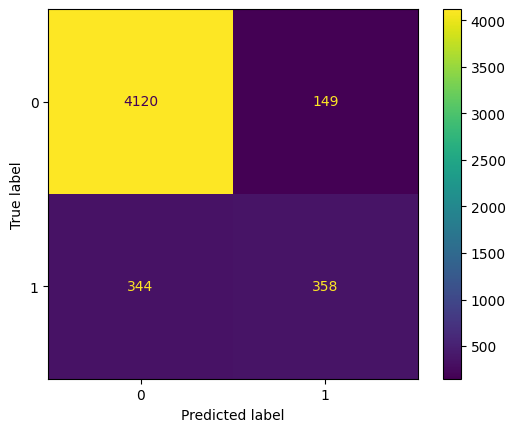

In [ ]:
# Run the model on the test set

pred_nn2 = model_nn2.predict(X_test_scaled2)

# Print the evaluation metrics

print(f'Accuracy: {accuracy_score(y2_test, pred_nn2.round()):.2f}')
print(f'Precision: {precision_score(y2_test, pred_nn2.round()):.2f}')
print(f'Recall: {recall_score(y2_test, pred_nn2.round()):.2f}')
print(f'F1: {f1_score(y2_test, pred_nn2.round()):.2f}')
print(f'AUC: {roc_auc_score(y2_test, pred_nn2.round()):.2f}')
cm_nn2 = confusion_matrix(y2_test, pred_nn2.round())
disp_nn2 = ConfusionMatrixDisplay(confusion_matrix=cm_nn2)
disp_nn2.plot()
plt.show()

This is an improvement on both the initial and tuned models on the Stage 1 dataset, and performs similarly to the XGBoost model on the Stage 2 dataset. Moreover, the recall is similar on the test set as it is on the training set in Stage 1. This is further evidence that the extra features added in the Stage 2 dataset have improved the predictive power of the models.

We will now hyperparameter tune the XGBoost and Neural Network models, aiming to improve model performance. We will start with XGBoost using Grid Search.

In [ ]:
# Set up the grid

param_grid2 = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [10, 15, 20, 30],
    'n_estimators': [50, 100, 200]
}

# Instantiate the model

model_xg2_tune = XGBClassifier(random_state=19)

# Perform Grid Search

grid_search2 = GridSearchCV(model_xg2_tune, param_grid2, scoring='recall', cv=5)
grid_search2.fit(X2_train, y2_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=19, ...),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [10, 15, 20, 30],
                         'n_estimators': [50, 100, 200]},
             scoring='recall')

In [ ]:
# Print the best parameters and score

print("Best parameters: ", grid_search2.best_params_)
print("Best recall score: ", grid_search2.best_score_)

Best parameters:  {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}
Best recall score:  0.6016478284271105


We will now print the evaluation metrics to compare them to the untuned model.

Accuracy: 0.91
Precision: 0.72
Recall: 0.58
F1: 0.64
AUC: 0.77


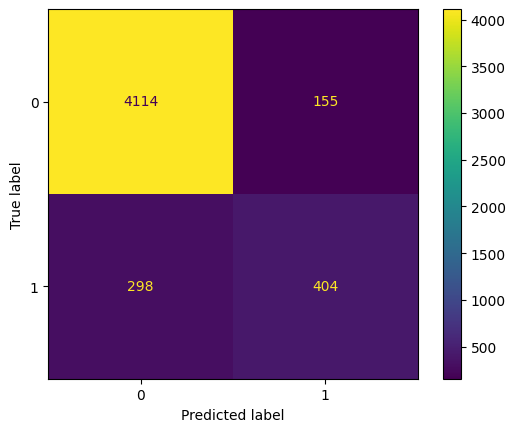

In [ ]:
# Instantiate the best model

model_xg2_opt = grid_search2.best_estimator_

# Run the best model on the test set

pred_xg2_opt = model_xg2_opt.predict(X2_test)

# Print the accuracy, precision, recall, F1 and AUC for the model, as well as the confusion matrix

print(f'Accuracy: {accuracy_score(y2_test, pred_xg2_opt):.2f}')
print(f'Precision: {precision_score(y2_test, pred_xg2_opt):.2f}')
print(f'Recall: {recall_score(y2_test, pred_xg2_opt):.2f}')
print(f'F1: {f1_score(y2_test, pred_xg2_opt):.2f}')
print(f'AUC: {roc_auc_score(y2_test, pred_xg2_opt):.2f}')
cm_xg2_opt = confusion_matrix(y2_test, pred_xg2_opt)
disp_xg2_opt = ConfusionMatrixDisplay(confusion_matrix=cm_xg2_opt, display_labels=model_xg2_opt.classes_)
disp_xg2_opt.plot()
plt.show()

This is a slight improvement over the untuned model from Stage 1, suggesting that there is a limit to how much hyperparameter tuning can improve a model. This implies that data quality is more important than model quality.

We will now tune the hyperparameters of the neural network. Contrary to Stage 1, we will do this all at once, as it can be left to run.

In [ ]:
# Define the search space

def build_model2(hp):
    model = keras.Sequential()

    # Add the input layer - the data does not need flattening but Flatten is used for simplicity
    model.add(layers.Flatten())

        # Tune the number of layers
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(
            layers.Dense(

        # Tune the number of neurons
                units=hp.Int('units', min_value=16, max_value=128, step=16),

        # Tune the activation function
                activation=hp.Choice('activation', ['relu', 'sigmoid', 'tanh']),

            ))


        # Tune whether to add Dropout *after* each hidden layer
        if hp.Boolean('use_dropout_' + str(i)): # Give each dropout a unique name

                                    # Tune the dropout rate
                                    dropout_rate = hp.Float('dropout_rate_' + str(i), min_value=0.0, max_value=0.5, step=0.05) # Give each dropout rate a unique name
                                    model.add(layers.Dropout(dropout_rate))


    model.add(layers.Dense(1, activation='sigmoid'))

        # Tune the optimiser
    optimiser_name = hp.Choice('optimiser', ['adam', 'rmsprop'])

    # Tune the learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    # Map the optimiser name to the optimizer class and instantiate

    if optimiser_name == 'adam':
        optimiser = Adam(learning_rate=learning_rate)
    elif optimiser_name == 'rmsprop':
        optimiser = RMSprop(learning_rate=learning_rate)
    else:
        # Default to Adam if something unexpected happens
        optimiser = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimiser,loss='binary_crossentropy',metrics=['recall'])

    return model

In [ ]:
# Set up the search

tuner_s2 = kt.RandomSearch(build_model2,
                        objective='val_recall',
                        max_trials=25,
                        overwrite=True)

# Run the search, implementing early stopping to conserve computational power

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner_s2.search(X_train_scaled2, y_train2, epochs=30, validation_data=(X_val_scaled2, y_val2), callbacks=[early_stopping])

Trial 25 Complete [00h 01m 20s]
val_recall: 0.5446265935897827

Best val_recall So Far: 0.7012750506401062
Total elapsed time: 00h 26m 09s


In [ ]:
# Return the best model

model_nn2_t = tuner_s2.get_best_models(num_models=1)[0]
model_nn2_t.summary()

tuner_s2.results_summary(1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (32, 386)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 80)               │        30,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 80)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 80)               │         6,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 1)                │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,521 (146.57 KB)

 Trainable params: 37,521 (146.57 KB)

 Non-trainable params: 0 (0.00 B)

Results summary
Results in ./untitled_project
Showing 1 best trials
Objective(name="val_recall", direction="max")

Trial 02 summary
Hyperparameters:
num_layers: 2
units: 80
activation: tanh
use_dropout_0: True
optimiser: rmsprop
learning_rate: 0.0012015815881560685
use_dropout_1: False
dropout_rate_0: 0.0
Score: 0.7012750506401062


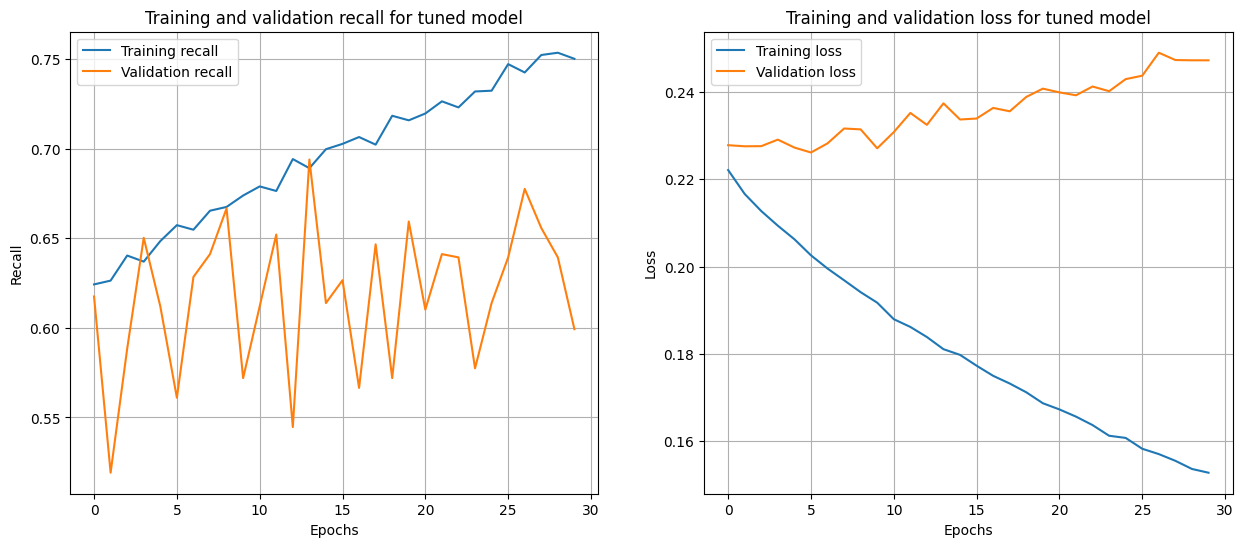

In [ ]:
# Plot the recall and loss curves

history = model_nn2_t.fit(X_train_scaled2, y_train2,
                               epochs=30, batch_size=128,
                               validation_data=(X_val_scaled2, y_val2),
                               verbose=0)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(model_nn2_t.history.history['recall'], label='Training recall')
plt.plot(model_nn2_t.history.history['val_recall'], label='Validation recall')
plt.title(f'Training and validation recall for tuned model')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(model_nn2_t.history.history['loss'], label='Training loss')
plt.plot(model_nn2_t.history.history['val_loss'], label='Validation loss')
plt.title(f'Training and validation loss for tuned model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

As in Stage 1, there is significant instability displayed on the plots. However, this was not fixed by tuning the batch size in Stage 1, therefore an attempt to tune the batch size will not be performed here. There is also still the presence of overfitting despite using dropout - this will have to be examined further.

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.90
Precision: 0.66
Recall: 0.57
F1: 0.61
AUC: 0.76


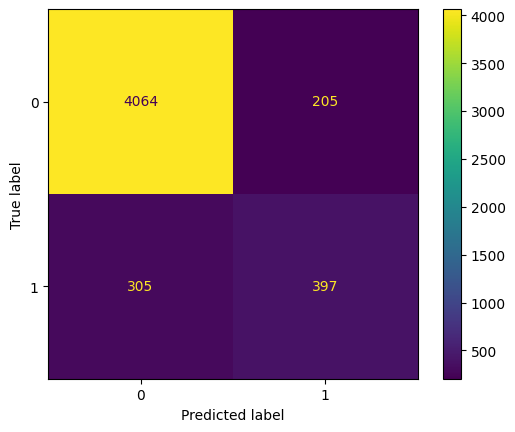

In [ ]:
# Run the model on the test set

pred_nn2_t = model_nn2_t.predict(X_test_scaled2)

# Show the evaluation metrics

print(f'Accuracy: {accuracy_score(y2_test, pred_nn2_t.round()):.2f}')
print(f'Precision: {precision_score(y2_test, pred_nn2_t.round()):.2f}')
print(f'Recall: {recall_score(y2_test, pred_nn2_t.round()):.2f}')
print(f'F1: {f1_score(y2_test, pred_nn2_t.round()):.2f}')
print(f'AUC: {roc_auc_score(y2_test, pred_nn2_t.round()):.2f}')
cm_nn2_t = confusion_matrix(y2_test, pred_nn2_t.round())
disp_nn2_t = ConfusionMatrixDisplay(confusion_matrix=cm_nn2_t)
disp_nn2_t.plot()
plt.show()


This shows a significant improvement in performance over both the previous neural network model (tuned on Stage 1 data, trained and tested on Stage 2 data) and the Stage 2 tuned XGBoost model.

This would suggest that the extra features added in the Stage 2 dataset have a significant positive impact on the predictive power of the model, and that tuning the model on the correct training set further improves it. This would also suggest that, for this data, a neural network is a better model than XGBoost.

# Stage 3 data

In [ ]:
# File URL
url_3 = "stage_3_data"

# Import the Stage 3 dataset into a DataFrame

df_3 = pd.read_csv(url_3)
df_3.head()

As previously, the cleaned dataset from Stage 2 will be used, with the new features from the Stage 3 dataset appended.

In [ ]:
# Create the Stage 3 dataset as the cleaned dataset plus the AssessedModule, PassedModule and FailedModule features

stage_3 = clean2.copy()
stage_3['AssessedModules'] = df_3['AssessedModules']
stage_3['PassedModules'] = df_3['PassedModules']
stage_3['FailedModules'] = df_3['FailedModules']
stage_3.head()

Now we will check the proportion of rows with missing values.

In [ ]:
# Count the number of rows with missing values

missing_rows3 = stage_3.isnull().any(axis=1).sum()

# Show that as a proportion of total rows

prop_missing_rows3 = (missing_rows3 / stage_3.shape[0])
print(f'Proportion of rows which have missing values: {prop_missing_rows3:.3f}')

Proportion of rows which have missing values: 0.092


This is more than 2% of the dataset. As such, we will impute missing values. The missing values are present in the features added in the new datasets for both Stages 2 and 3. These features are all numerical, as such, using a mean or median is appropriate. We will plot these features on boxplots to examine the distribution of the data.

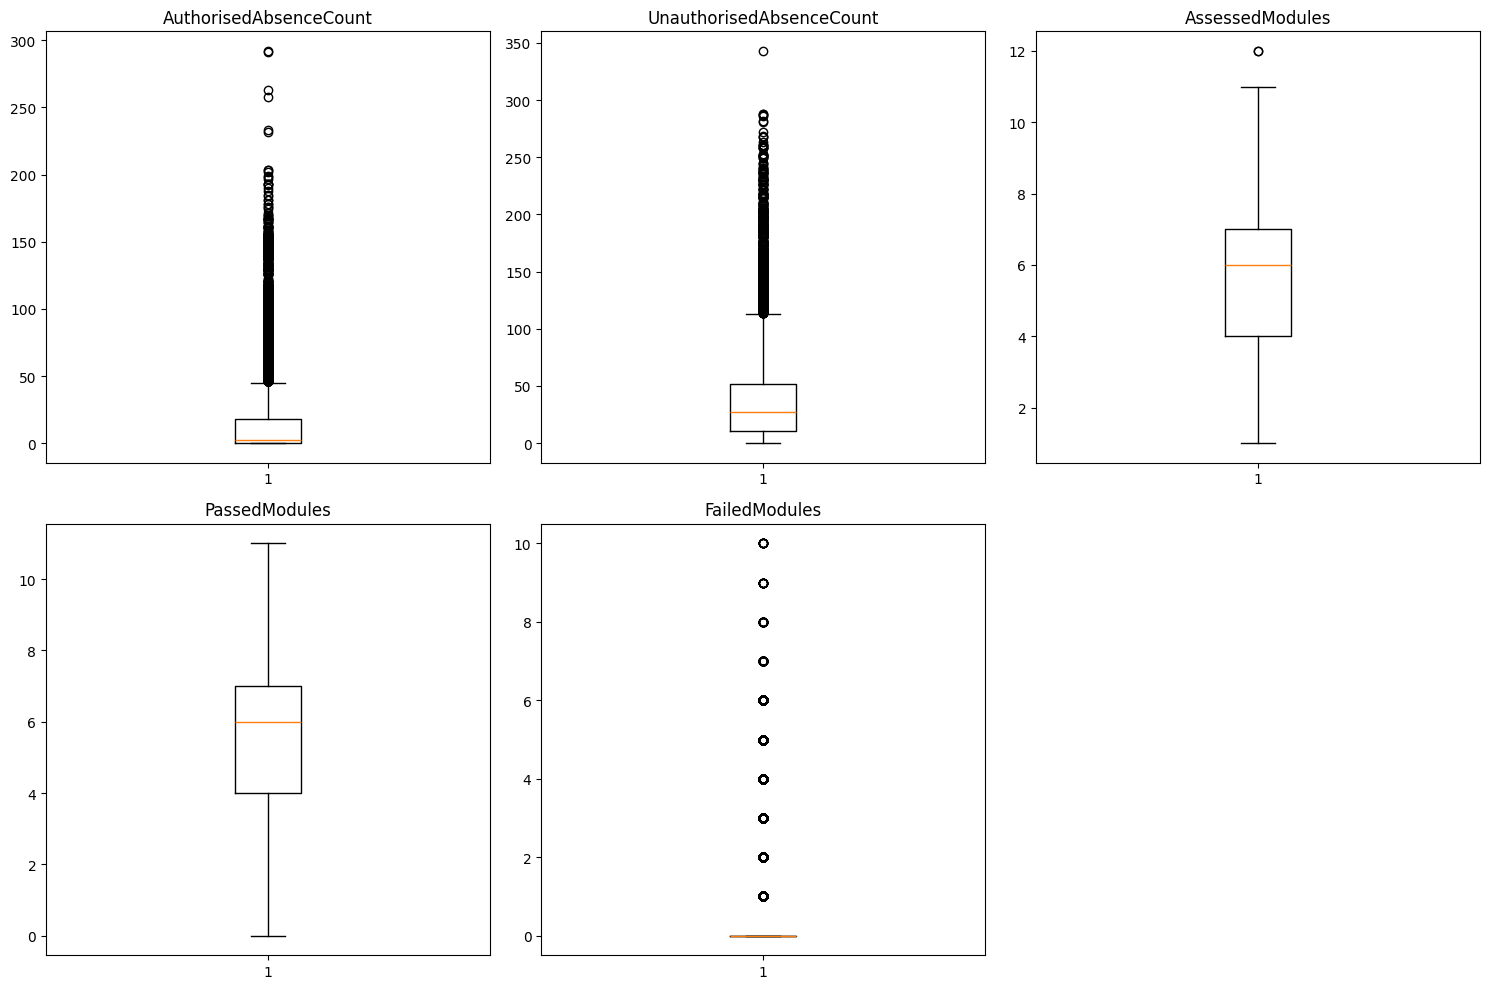

In [ ]:
# Create a dummy dataset with the NA's removed

stage_3_dummy = stage_3.dropna()

# Plot the AuthorisedAbsence, UnauthorisedAbsence, AssessedModules, PassedModules and FailedModules features on boxplots

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.boxplot(stage_3_dummy['AuthorisedAbsenceCount'])
plt.title('AuthorisedAbsenceCount')

plt.subplot(2, 3, 2)
plt.boxplot(stage_3_dummy['UnauthorisedAbsenceCount'])
plt.title('UnauthorisedAbsenceCount')

plt.subplot(2, 3, 3)
plt.boxplot(stage_3_dummy['AssessedModules'])
plt.title('AssessedModules')

plt.subplot(2, 3, 4)
plt.boxplot(stage_3_dummy['PassedModules'])
plt.title('PassedModules')

plt.subplot(2, 3, 5)
plt.boxplot(stage_3_dummy['FailedModules'])
plt.title('FailedModules')

plt.tight_layout()
plt.show()



The AuthorisedAbsenceCount, UnauthorisedAbsenceCount and FailedModules features all have significant outliers. As such, it would be inappropriate to use the mean to impute these values, as the mean is offset by outliers. We will therefore use the median - this will be used for the AssessedModules and PassedModules features as well for consistency.

In [ ]:
# Impute missing values with the median

stage_3['AuthorisedAbsenceCount'] = stage_3['AuthorisedAbsenceCount'].fillna(stage_3['AuthorisedAbsenceCount'].median())
stage_3['UnauthorisedAbsenceCount'] = stage_3['UnauthorisedAbsenceCount'].fillna(stage_3['UnauthorisedAbsenceCount'].median())
stage_3['AssessedModules'] = stage_3['AssessedModules'].fillna(stage_3['AssessedModules'].median())
stage_3['PassedModules'] = stage_3['PassedModules'].fillna(stage_3['PassedModules'].median())
stage_3['FailedModules'] = stage_3['FailedModules'].fillna(stage_3['FailedModules'].median())

stage_3.head()

,CentreName,Gender,Nationality,CourseLevel,CourseName,IsFirstIntake,Target,ProgressionUniversity,Age,AuthorisedAbsenceCount,UnauthorisedAbsenceCount,AssessedModules,PassedModules,FailedModules
0,ISC_Aberdeen,0,Chinese,4,Business and Law Pre-Masters,True,0,University of Aberdeen,27,1.0,29.0,4.0,4.0,0.0
1,ISC_Aberdeen,0,Chinese,1,Life Sciences Undergraduate Foundation Programme,False,0,University of Aberdeen,27,93.0,5.0,7.0,7.0,0.0
2,ISC_Aberdeen,0,Chinese,3,Business Management and Finance International ...,False,0,University of Aberdeen,25,92.0,6.0,8.0,8.0,0.0
3,ISC_Aberdeen,0,Chinese,3,Business Management and Finance International ...,True,0,University of Aberdeen,26,67.0,15.0,8.0,8.0,0.0
4,ISC_Aberdeen,0,Chinese,4,Business and Law Pre-Masters,True,0,University of Aberdeen,29,1.0,29.0,4.0,4.0,0.0


Once again, the cardinal features need to be one-hot encoded. As all of the new features in the Stage 3 dataset have ordinal data, this will only apply to the CentreName, CourseName and ProgressionUniversity features as before.

In [ ]:
# Perform One-Hot Encoding

encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_features_3 = encoder.fit_transform(stage_3[['CentreName', 'CourseName', 'ProgressionUniversity','Nationality']])
encoded_3 = pd.DataFrame(encoded_features_3, columns=encoder.get_feature_names_out(['CentreName', 'CourseName', 'ProgressionUniversity','Nationality']))
stage_3 = pd.concat([stage_3, encoded_3], axis=1)
stage_3.drop(['CentreName', 'CourseName', 'ProgressionUniversity','Nationality'], axis=1, inplace=True)
stage_3.head()

,Gender,CourseLevel,IsFirstIntake,Target,Age,AuthorisedAbsenceCount,UnauthorisedAbsenceCount,AssessedModules,PassedModules,FailedModules,...,Nationality_Turkmen,Nationality_Ugandan,Nationality_Ukrainian,Nationality_Uruguayan,Nationality_Uzbek,Nationality_Venezuelan,Nationality_Vietnamese,Nationality_Yemeni,Nationality_Zambian,Nationality_Zimbabwean
0,0,4,True,0,27,1.0,29.0,4.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1,False,0,27,93.0,5.0,7.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,3,False,0,25,92.0,6.0,8.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,3,True,0,26,67.0,15.0,8.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,4,True,0,29,1.0,29.0,4.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


With the Stage 3 dataset now completely prepared, we can start the model-building process. As usual, we start by splitting the data into training and test sets.

In [ ]:
# Split the data into X and y

X3 = stage_3.drop('Target', axis=1)
y3 = stage_3['Target']

# Split X into a training and test set

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=19)

We will start by building the XGBoost model. As in Stage 2, we will use the best hyperparameters from the previous Stage.

Accuracy: 0.98
Precision: 0.94
Recall: 0.88
F1: 0.91
AUC: 0.94


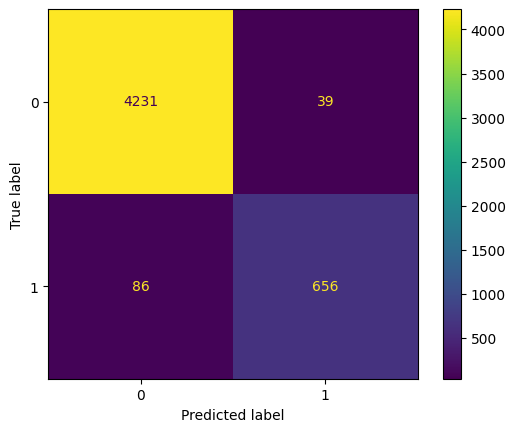

In [ ]:
# Instantiate the XGBoost model

model_xg3 = XGBClassifier(learning_rate=0.2, max_depth=10, n_estimators=200, random_state=19)
model_xg3.fit(X3_train, y3_train)

# Run the model on the test set

pred_xg3 = model_xg3.predict(X3_test)

# Print the evaluation metrics

print(f'Accuracy: {accuracy_score(y3_test, pred_xg3):.2f}')
print(f'Precision: {precision_score(y3_test, pred_xg3):.2f}')
print(f'Recall: {recall_score(y3_test, pred_xg3):.2f}')
print(f'F1: {f1_score(y3_test, pred_xg3):.2f}')
print(f'AUC: {roc_auc_score(y3_test, pred_xg3):.2f}')
cm_xg3 = confusion_matrix(y3_test, pred_xg3)
disp_xg3 = ConfusionMatrixDisplay(confusion_matrix=cm_xg3, display_labels=model_xg3.classes_)
disp_xg3.plot()
plt.show()

The performance of this model is excellent, showing a marked improvement over both the XGBoost and neural network models (post-hyperparameter tuning) from Stage 2. This would imply that the extra features provided in the Stage 3 dataset are significant in providing the model with the data needed to predict student dropout.

To determine whether this is correct, SHAP values could be calculated and a beeswarm plot could be created to identify whether these new features are indeed the most important.

We will now build the neural network model using the best hyperparameters from Stage 2. However, we first need to split the data into training and validation, and scale the data.

In [ ]:
# Split the data into training and validation sets

X_train3, X_val3, y_train3, y_val3 = train_test_split(X3_train, y3_train, test_size=0.2, random_state=19)

# Scale the data

scaler = StandardScaler()
X_train_scaled3 = scaler.fit_transform(X_train3)
X_val_scaled3 = scaler.transform(X_val3)
X_test_scaled3 = scaler.transform(X3_test)

In [ ]:
# Get the best hyperparameters from the Stage 2 model

best_hps_3 = tuner_s2.get_best_hyperparameters(num_trials=1)[0].values

num_layers_s2 = best_hps_3.get('num_layers')
num_neurons_s2 = best_hps_3.get('units')
activation_s2 = best_hps_3.get('activation')
optimiser_s2 = best_hps_3.get('optimiser')
learning_rate_s2 = best_hps_3.get('learning_rate')

# Determine the dropout rate and whether dropout was used for each layer
dropout_rates2 = {}
use_dropout2 = {}
for i in range(num_layers_s2):
    # Check if the boolean choice for dropout existed and was True for this layer
    dropout_key2 = f'use_dropout_{i}'
    if dropout_key2 in best_hps_3 and best_hps_3.get(dropout_key2) is True:
        use_dropout2[i] = True
        # Only get the dropout rate if dropout was used for this layer
        dropout_rate_key2 = f'dropout_rate_{i}'
        if dropout_rate_key2 in best_hps_3:
             dropout_rates2[i] = best_hps_3.get(dropout_rate_key2)
        else:
             # If dropout was True but the rate wasn't tuned (e.g., if it was fixed at 0.0 in tuning setup)
             dropout_rates2[i] = 0.0
    else:
        use_dropout2[i] = False
        dropout_rates2[i] = 0.0 # Default to 0.0 if dropout was not used for this layer

In [ ]:
# Instantiate the optimal model

model_nn3 = keras.Sequential()
model_nn3.add(layers.Input(shape=(X_train_scaled3.shape[1],)))

# Add the hidden layers with the optimal number of neurons and activation function
for i in range(num_layers_s2):
    model_nn3.add(layers.Dense(units=num_neurons_s2, activation=activation_s2))
    # Add dropout if it was found to be optimal for this layer
    if use_dropout2.get(i, False): # Check if dropout was tuned for this layer and if it was True
        model_nn3.add(layers.Dropout(dropout_rates2.get(i, 0.0))) # Use the tuned dropout rate

# Add the output layer
model_nn3.add(layers.Dense(1, activation='sigmoid'))

# Compile the model with the optimal optimizer and learning rate

if optimiser_s2 == 'adam':
    optimiser = Adam(learning_rate=learning_rate_s2)
elif optimiser_s2 == 'rmsprop':
    optimiser = RMSprop(learning_rate=learning_rate_s2)
else:
    # Default to Adam if something unexpected happens
    optimiser = Adam(learning_rate=learning_rate_s2)


model_nn3.compile(optimizer=optimiser, loss='binary_crossentropy', metrics=['recall'])


We will run the model on the test set and show the evaluation metrics

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.51
Precision: 0.14
Recall: 0.45
F1: 0.21
AUC: 0.49


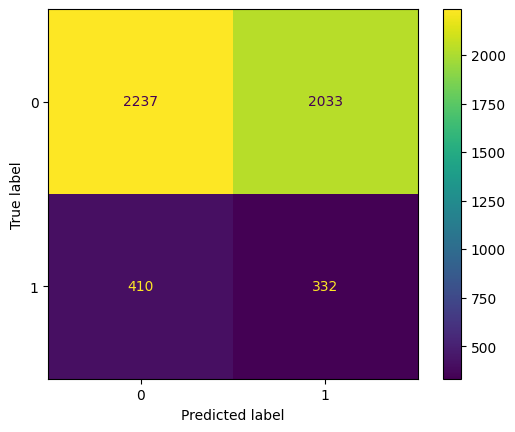

In [ ]:
# Run the model on the test set

pred_nn3 = model_nn3.predict(X_test_scaled3)

# Show the evaluation metrics

print(f'Accuracy: {accuracy_score(y3_test, pred_nn3.round()):.2f}')
print(f'Precision: {precision_score(y3_test, pred_nn3.round()):.2f}')
print(f'Recall: {recall_score(y3_test, pred_nn3.round()):.2f}')
print(f'F1: {f1_score(y3_test, pred_nn3.round()):.2f}')
print(f'AUC: {roc_auc_score(y3_test, pred_nn3.round()):.2f}')
cm_nn3 = confusion_matrix(y3_test, pred_nn3.round())
disp_nn3 = ConfusionMatrixDisplay(confusion_matrix=cm_nn3)
disp_nn3.plot()
plt.show()

This is a significant decline from the Stage 2 tuned models in terms of recall, and precision has dropped drastically, suggesting that the lack of hyperparameter tuning on the Stage 3 dataset has resulted in a neural network which is not suited to predicitng dropout with the new dataset.

Clearly, the XGBoost model has performed better than the neural network on the Stage 3 dataset, and is the one that ought to be used going forwards to predict student dropout rate.

It is important to note, however, that neither model was tuned on the Stage 3 dataset. The results of this project show that XGBoost is a good model and, once a model is created and tuned, it is suited to being trained on datasets with some different features. This is in contrast to the neural network, which sees its performance suffer in comparison when a tuned model is instantiated and trained on a new dataset with features that were not present when tuning took place. This could be summarised as XGBoost being a more robust model, whilst a neural network needs to be tuned to perform well. We could attempt to confirm this hypothesis by tuning the hyperparameters of the neural network on the Stage 3 dataset and seeing if performance improves.

---

Overall, the XGBoost model can be a good predictor of student dropout. However, ideally we would want to intervene at an earlier stage to maximise the chances of improving student outcomes. As such, further iterations of this project will have to be done to create a model which can predict student dropout in a timely manner. The focus of these next steps should be on the input data, as data quality is far more important than model quality.